## Import and install dependencies

In [1]:
## Download TorchVision repo
!rm -r vision
!git init
!pip install pycocotools --quiet
!pip install torchvision --quiet
!git config --global --unset http.proxy 
!git config --global --unset https.proxy
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

!rm -r jpgImages
!mkdir jpgImages

## Basic libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from sklearn.model_selection import train_test_split
import pydicom
from skimage.transform import resize

## Torchvision libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter

## Image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms


## Helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

rm: cannot remove 'vision': No such file or directory
Initialized empty Git repository in /kaggle/working/.git/
Cloning into 'vision'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 15529 (delta 133), reused 99 (delta 68), pack-reused 15345
Receiving objects: 100% (15529/15529), 16.14 MiB | 21.92 MiB/s, done.
Resolving deltas: 100% (11044/11044), done.
rm: cannot remove 'jpgImages': No such file or directory


## Data access and cleaning


In [2]:
## Parent path to data
path = '/kaggle/input/rsna-pneumonia-detection-challenge/'

boxCSV = 'stage_2_train_labels.csv'
dataCSV = 'stage_2_detailed_class_info.csv'

imageFolders = ['stage_2_test_images', 'stage_2_train_images']

## First class is background
classes = [_, 1]

## Image data
dataDF = pd.read_csv(path + dataCSV)
## Box data
boxDF = pd.read_csv(path + boxCSV)

dataGlob = glob('/kaggle/input/rsna-pneumonia-detection-challenge/*images/*.dcm')

## Dictionary of image to path
imagePaths = {os.path.basename(x)[:-4]: x for x in dataGlob}
## Full image path data table
dataPath = dataDF['patientId'].map(imagePaths.get)

## Full path to images with bounding boxes
boxPaths= boxDF['patientId'].map(imagePaths.get)
## Isolate images with bounding boxes
boxImages = pd.merge(left = boxDF, right = dataDF, left_on = 'patientId', right_on = 'patientId', how = 'inner')
boxImages.dropna(axis = 0, inplace = True)
boxDF.dropna(axis = 0, inplace = True)

## Bounding box and label data groupings by image. Using boxDF due to inner join duplication
xBox = boxDF.groupby('patientId')['x'].apply(np.array).reset_index()['x'].values
yBox = boxDF.groupby('patientId')['y'].apply(np.array).reset_index()['y'].values
wBox = boxDF.groupby('patientId')['width'].apply(np.array).reset_index()['width'].values
hBox = boxDF.groupby('patientId')['height'].apply(np.array).reset_index()['height'].values
## Group the finding labels together for the varying bounding boxes in each image
boxLabel = boxDF.groupby('patientId')['Target'].apply(np.array).reset_index()
boxLabel['paths'] = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/" + boxLabel['patientId'] + ".dcm"

print("Number of images: ", len(boxLabel))

Number of images:  6012


## Convert dicom to jpg and store images

In [3]:
## Convert dicom files to jpg images and write to directory
def dicomToJpg():
    imageDict = {'Directory':[], 'ID':[]}
    for i in range(len(boxLabel)):
        imageArr = pydicom.dcmread(boxLabel.iloc[i]['paths']).pixel_array
        imageName = boxLabel.iloc[i]['patientId']
        jpgName = imageName + ('.jpg')
        cv2.imwrite(os.path.join('/kaggle/working/jpgImages', jpgName), imageArr)
        imageDict['Directory'].append(os.path.join('/kaggle/working/jpgImages', jpgName))
        imageDict['ID'].append(imageName)
    return pd.DataFrame(imageDict)
jpgImages = dicomToJpg()

## Data preprocessing

In [4]:
## Create a dictionary object for each image with its bounding box coords and labels
class LungData(torch.utils.data.Dataset):
    def __init__(self, height, width, transforms = None):
        self.height = height
        self.width = width
        self.len = len(boxLabel)
        self.transforms = transforms
    
    ## Overwrite and return the image dictionary
    def __getitem__(self, index):
        imagePath = jpgImages['Directory'].iloc[index]

        # Read and resize the image
        origImage = cv2.imread(imagePath)
        image = cv2.cvtColor(origImage, cv2.COLOR_BGR2GRAY).astype(np.float32)
        image = cv2.resize(image, (self.width, self.height), cv2.INTER_AREA)
        image = image / 255.0
        
        
        ## Combine all boxes for an image together
        boxes = []
        labels = []
        
        ## Original image shape for normalizing (both 1024)
        Wimage = origImage.shape[1]
        Himage = origImage.shape[0]

        ## Create dictionary with image info and boxes
        for member in range(len(boxLabel['Target'].iloc[index])):
            labels.append(classes.index(boxLabel['Target'].iloc[index][member]))
                          
            xMin = xBox[index][member]
            xMax = xBox[index][member] + wBox[index][member]
            
            yMin = yBox[index][member]
            yMax = yBox[index][member] + hBox[index][member]
            
            xMinCorr = (xMin/Wimage) * self.width
            xMaxCorr = (xMax/Wimage) * self.width
            yMinCorr = (yMin/Himage) * self.height
            yMaxCorr = (yMax/Himage) * self.height
            
            boxes.append([xMinCorr, yMinCorr, xMaxCorr, yMaxCorr])
        
        ## Convert bounding boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        ## Calculate area of boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        ## Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        ## Create output dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        imageId = torch.tensor([index])
        target["image_id"] = imageId
        
        # Apply data transformations to reduce overfitting
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
               
        return image, target
    
    ## Overwrite function to return length of dataset
    def __len__(self):
        return self.len


## Check dataset length
dataset = LungData(256, 256)
print("Length of dataset: ", len(dataset), "\n")

## Sample index to show image dictionary output
image, target = dataset[878]
print("Image shape: ", image.shape, "\n")
print("Image dictionary object: ", target)

Length of dataset:  6012 

Image shape:  (256, 256) 

Image dictionary object:  {'boxes': tensor([[159.2500,  99.7500, 212.7500, 165.5000],
        [ 63.5000, 105.2500, 111.0000, 165.7500]]), 'labels': tensor([1, 1]), 'area': tensor([3517.6250, 2873.7500]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([878])}


## Visualize an X-Ray image with bounding box

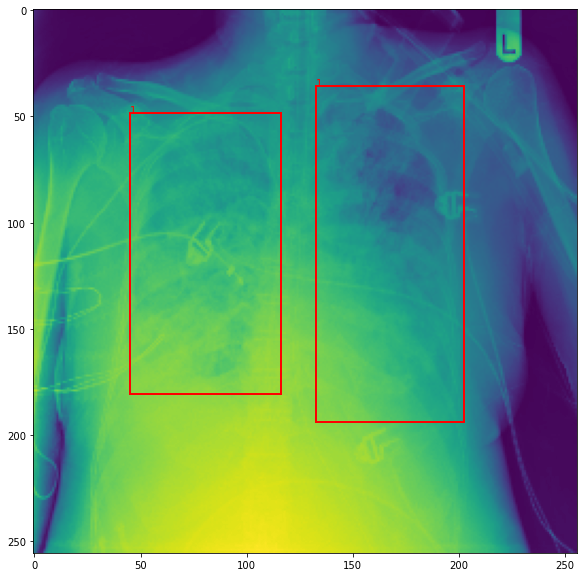

In [26]:
## Plot an image and overlay its bounding box on top of it
def plotImage(image, target, color):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(image)
    ## get the context for drawing boxes
    ax = plt.gca()
    ## Plot each box
    for i in range(len(target['boxes'])):
        box = target['boxes'][i]
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        ## Create rectangle patch for bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = color, facecolor = 'none')
        ax.add_patch(rect)
        ## Draw text on top of box
        label = "%s" % (classes[target['labels'][i]])
        plt.text(x, y, label, color='red')
    ## show the plot
    plt.show()
    
## Plot a sample image
image, target = dataset[175]
plotImage(image, target, 'r')

## Import ResNet-50-FPN model

In [6]:
## Create the base model to be trained
def detectionModel(numClasses):
    ## Load a model pretrained resnet model to speed training time
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    ## Get number of input features for the classifier
    inFeatures = model.roi_heads.box_predictor.cls_score.in_features
    ## Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses) 

    return model

## Data transformations during training to reduce overfit
def createTransform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Split training and test data

In [7]:
## Initialize train and test objects
dataTrain = LungData(256, 256, createTransform(False))
dataTest = LungData(256, 256, createTransform(False))

## Split the dataset into train and test sets
torch.manual_seed(1)
indices = torch.randperm(len(dataTrain)).tolist()
dataSplit = 0.2
testSize = int(len(dataTrain)*dataSplit)
dataTrain = torch.utils.data.Subset(dataTrain, indices[:-testSize])
dataTest = torch.utils.data.Subset(dataTest, indices[-testSize:])

## Define training and validation data loaders
dataTrainLoader = torch.utils.data.DataLoader(dataTrain, batch_size=10, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
dataTestLoader = torch.utils.data.DataLoader(dataTest, batch_size=10, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

## Initialize model

In [8]:
## Determine if we can use a GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Initialize model
numClasses = 2
model = detectionModel(numClasses)
# model.double()
model.to(device)

## Construct an optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0055, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
lrScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## Train the model

In [9]:
## Choose number of training epochs
numEpochs = 25

## Tensorboard writer
# writer = SummaryWriter()

## Train one epoch at a time for numEpochs
for epoch in range(numEpochs):
    train_one_epoch(model, optimizer, dataTrainLoader, device, epoch, print_freq=10)
    ## Update the learning rate
    lrScheduler.step()
    ## Evaluate on the test dataset
    evaluate(model, dataTestLoader, device=device)

Epoch: [0]  [  0/481]  eta: 0:20:55  lr: 0.000017  loss: 0.9023 (0.9023)  loss_classifier: 0.6705 (0.6705)  loss_box_reg: 0.0873 (0.0873)  loss_objectness: 0.1277 (0.1277)  loss_rpn_box_reg: 0.0168 (0.0168)  time: 2.6103  data: 0.5670  max mem: 7131
Epoch: [0]  [ 10/481]  eta: 0:09:46  lr: 0.000131  loss: 0.7549 (0.7518)  loss_classifier: 0.6089 (0.5544)  loss_box_reg: 0.0831 (0.0869)  loss_objectness: 0.0850 (0.0975)  loss_rpn_box_reg: 0.0131 (0.0129)  time: 1.2448  data: 0.0810  max mem: 7398
Epoch: [0]  [ 20/481]  eta: 0:09:07  lr: 0.000246  loss: 0.3948 (0.5512)  loss_classifier: 0.2583 (0.3641)  loss_box_reg: 0.0831 (0.0879)  loss_objectness: 0.0782 (0.0878)  loss_rpn_box_reg: 0.0109 (0.0115)  time: 1.1154  data: 0.0324  max mem: 7398
Epoch: [0]  [ 30/481]  eta: 0:08:43  lr: 0.000360  loss: 0.3250 (0.4753)  loss_classifier: 0.1425 (0.2918)  loss_box_reg: 0.1044 (0.1000)  loss_objectness: 0.0543 (0.0729)  loss_rpn_box_reg: 0.0091 (0.0106)  time: 1.1135  data: 0.0318  max mem: 7398


Epoch: [0]  [330/481]  eta: 0:02:47  lr: 0.003794  loss: 0.3065 (0.3399)  loss_classifier: 0.1183 (0.1416)  loss_box_reg: 0.1713 (0.1681)  loss_objectness: 0.0113 (0.0232)  loss_rpn_box_reg: 0.0057 (0.0070)  time: 1.1025  data: 0.0309  max mem: 7398
Epoch: [0]  [340/481]  eta: 0:02:36  lr: 0.003909  loss: 0.3106 (0.3385)  loss_classifier: 0.1227 (0.1408)  loss_box_reg: 0.1632 (0.1678)  loss_objectness: 0.0116 (0.0229)  loss_rpn_box_reg: 0.0057 (0.0070)  time: 1.1079  data: 0.0317  max mem: 7398
Epoch: [0]  [350/481]  eta: 0:02:25  lr: 0.004023  loss: 0.2954 (0.3376)  loss_classifier: 0.1144 (0.1402)  loss_box_reg: 0.1599 (0.1678)  loss_objectness: 0.0116 (0.0226)  loss_rpn_box_reg: 0.0059 (0.0069)  time: 1.1077  data: 0.0320  max mem: 7398
Epoch: [0]  [360/481]  eta: 0:02:14  lr: 0.004138  loss: 0.3061 (0.3367)  loss_classifier: 0.1144 (0.1396)  loss_box_reg: 0.1635 (0.1678)  loss_objectness: 0.0123 (0.0224)  loss_rpn_box_reg: 0.0060 (0.0069)  time: 1.1042  data: 0.0323  max mem: 7398


Epoch: [1]  [110/481]  eta: 0:06:53  lr: 0.005500  loss: 0.2816 (0.2880)  loss_classifier: 0.1143 (0.1102)  loss_box_reg: 0.1639 (0.1616)  loss_objectness: 0.0093 (0.0106)  loss_rpn_box_reg: 0.0053 (0.0057)  time: 1.1082  data: 0.0323  max mem: 7398
Epoch: [1]  [120/481]  eta: 0:06:41  lr: 0.005500  loss: 0.2796 (0.2887)  loss_classifier: 0.1073 (0.1100)  loss_box_reg: 0.1617 (0.1625)  loss_objectness: 0.0085 (0.0105)  loss_rpn_box_reg: 0.0052 (0.0057)  time: 1.1047  data: 0.0325  max mem: 7398
Epoch: [1]  [130/481]  eta: 0:06:30  lr: 0.005500  loss: 0.2900 (0.2899)  loss_classifier: 0.1107 (0.1105)  loss_box_reg: 0.1617 (0.1633)  loss_objectness: 0.0089 (0.0104)  loss_rpn_box_reg: 0.0059 (0.0057)  time: 1.1096  data: 0.0322  max mem: 7398
Epoch: [1]  [140/481]  eta: 0:06:19  lr: 0.005500  loss: 0.2900 (0.2898)  loss_classifier: 0.1107 (0.1103)  loss_box_reg: 0.1613 (0.1635)  loss_objectness: 0.0088 (0.0102)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 1.1104  data: 0.0310  max mem: 7398


Epoch: [1]  [440/481]  eta: 0:00:45  lr: 0.005500  loss: 0.2790 (0.2856)  loss_classifier: 0.1019 (0.1085)  loss_box_reg: 0.1622 (0.1622)  loss_objectness: 0.0075 (0.0094)  loss_rpn_box_reg: 0.0057 (0.0055)  time: 1.1088  data: 0.0309  max mem: 7398
Epoch: [1]  [450/481]  eta: 0:00:34  lr: 0.005500  loss: 0.2795 (0.2860)  loss_classifier: 0.1029 (0.1086)  loss_box_reg: 0.1663 (0.1625)  loss_objectness: 0.0088 (0.0094)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 1.1092  data: 0.0313  max mem: 7398
Epoch: [1]  [460/481]  eta: 0:00:23  lr: 0.005500  loss: 0.2880 (0.2858)  loss_classifier: 0.1048 (0.1085)  loss_box_reg: 0.1651 (0.1623)  loss_objectness: 0.0089 (0.0094)  loss_rpn_box_reg: 0.0048 (0.0055)  time: 1.1040  data: 0.0305  max mem: 7398
Epoch: [1]  [470/481]  eta: 0:00:12  lr: 0.005500  loss: 0.2835 (0.2858)  loss_classifier: 0.1081 (0.1086)  loss_box_reg: 0.1549 (0.1623)  loss_objectness: 0.0089 (0.0095)  loss_rpn_box_reg: 0.0050 (0.0055)  time: 1.1063  data: 0.0316  max mem: 7398


Epoch: [2]  [220/481]  eta: 0:04:49  lr: 0.005500  loss: 0.2568 (0.2691)  loss_classifier: 0.0980 (0.1006)  loss_box_reg: 0.1501 (0.1551)  loss_objectness: 0.0065 (0.0081)  loss_rpn_box_reg: 0.0047 (0.0053)  time: 1.1075  data: 0.0314  max mem: 7398
Epoch: [2]  [230/481]  eta: 0:04:38  lr: 0.005500  loss: 0.2737 (0.2695)  loss_classifier: 0.0987 (0.1008)  loss_box_reg: 0.1605 (0.1553)  loss_objectness: 0.0080 (0.0081)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 1.1084  data: 0.0319  max mem: 7398
Epoch: [2]  [240/481]  eta: 0:04:27  lr: 0.005500  loss: 0.2621 (0.2702)  loss_classifier: 0.0975 (0.1010)  loss_box_reg: 0.1564 (0.1558)  loss_objectness: 0.0075 (0.0081)  loss_rpn_box_reg: 0.0054 (0.0053)  time: 1.1101  data: 0.0325  max mem: 7398
Epoch: [2]  [250/481]  eta: 0:04:16  lr: 0.005500  loss: 0.2610 (0.2697)  loss_classifier: 0.0962 (0.1008)  loss_box_reg: 0.1538 (0.1555)  loss_objectness: 0.0062 (0.0080)  loss_rpn_box_reg: 0.0050 (0.0053)  time: 1.1085  data: 0.0325  max mem: 7398


Epoch: [3]  [  0/481]  eta: 0:12:51  lr: 0.000550  loss: 0.2018 (0.2018)  loss_classifier: 0.0650 (0.0650)  loss_box_reg: 0.1285 (0.1285)  loss_objectness: 0.0056 (0.0056)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 1.6049  data: 0.4124  max mem: 7398
Epoch: [3]  [ 10/481]  eta: 0:09:02  lr: 0.000550  loss: 0.2511 (0.2482)  loss_classifier: 0.0884 (0.0921)  loss_box_reg: 0.1399 (0.1461)  loss_objectness: 0.0058 (0.0058)  loss_rpn_box_reg: 0.0040 (0.0043)  time: 1.1511  data: 0.0649  max mem: 7398
Epoch: [3]  [ 20/481]  eta: 0:08:41  lr: 0.000550  loss: 0.2568 (0.2513)  loss_classifier: 0.0930 (0.0938)  loss_box_reg: 0.1501 (0.1465)  loss_objectness: 0.0061 (0.0063)  loss_rpn_box_reg: 0.0048 (0.0047)  time: 1.1084  data: 0.0307  max mem: 7398
Epoch: [3]  [ 30/481]  eta: 0:08:26  lr: 0.000550  loss: 0.2617 (0.2517)  loss_classifier: 0.0936 (0.0941)  loss_box_reg: 0.1499 (0.1469)  loss_objectness: 0.0058 (0.0060)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 1.1082  data: 0.0306  max mem: 7398


Epoch: [3]  [330/481]  eta: 0:02:47  lr: 0.000550  loss: 0.2480 (0.2546)  loss_classifier: 0.0922 (0.0935)  loss_box_reg: 0.1483 (0.1504)  loss_objectness: 0.0055 (0.0059)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.1118  data: 0.0329  max mem: 7398
Epoch: [3]  [340/481]  eta: 0:02:36  lr: 0.000550  loss: 0.2698 (0.2553)  loss_classifier: 0.0966 (0.0937)  loss_box_reg: 0.1567 (0.1509)  loss_objectness: 0.0051 (0.0059)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 1.1120  data: 0.0333  max mem: 7398
Epoch: [3]  [350/481]  eta: 0:02:25  lr: 0.000550  loss: 0.2718 (0.2557)  loss_classifier: 0.0963 (0.0937)  loss_box_reg: 0.1577 (0.1512)  loss_objectness: 0.0051 (0.0059)  loss_rpn_box_reg: 0.0050 (0.0048)  time: 1.1070  data: 0.0319  max mem: 7398
Epoch: [3]  [360/481]  eta: 0:02:14  lr: 0.000550  loss: 0.2359 (0.2549)  loss_classifier: 0.0860 (0.0935)  loss_box_reg: 0.1419 (0.1506)  loss_objectness: 0.0052 (0.0059)  loss_rpn_box_reg: 0.0042 (0.0048)  time: 1.1075  data: 0.0332  max mem: 7398


Epoch: [4]  [110/481]  eta: 0:06:54  lr: 0.000550  loss: 0.2539 (0.2489)  loss_classifier: 0.0893 (0.0906)  loss_box_reg: 0.1484 (0.1485)  loss_objectness: 0.0045 (0.0051)  loss_rpn_box_reg: 0.0048 (0.0047)  time: 1.1119  data: 0.0330  max mem: 7398
Epoch: [4]  [120/481]  eta: 0:06:42  lr: 0.000550  loss: 0.2484 (0.2491)  loss_classifier: 0.0906 (0.0908)  loss_box_reg: 0.1419 (0.1485)  loss_objectness: 0.0045 (0.0051)  loss_rpn_box_reg: 0.0043 (0.0047)  time: 1.1079  data: 0.0321  max mem: 7398
Epoch: [4]  [130/481]  eta: 0:06:31  lr: 0.000550  loss: 0.2402 (0.2483)  loss_classifier: 0.0865 (0.0906)  loss_box_reg: 0.1370 (0.1480)  loss_objectness: 0.0037 (0.0050)  loss_rpn_box_reg: 0.0044 (0.0047)  time: 1.1111  data: 0.0322  max mem: 7398
Epoch: [4]  [140/481]  eta: 0:06:20  lr: 0.000550  loss: 0.2465 (0.2500)  loss_classifier: 0.0910 (0.0912)  loss_box_reg: 0.1468 (0.1491)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0049 (0.0048)  time: 1.1106  data: 0.0325  max mem: 7398


Epoch: [4]  [440/481]  eta: 0:00:45  lr: 0.000550  loss: 0.2536 (0.2493)  loss_classifier: 0.0909 (0.0911)  loss_box_reg: 0.1477 (0.1481)  loss_objectness: 0.0048 (0.0054)  loss_rpn_box_reg: 0.0050 (0.0047)  time: 1.1067  data: 0.0321  max mem: 7398
Epoch: [4]  [450/481]  eta: 0:00:34  lr: 0.000550  loss: 0.2430 (0.2491)  loss_classifier: 0.0881 (0.0910)  loss_box_reg: 0.1466 (0.1480)  loss_objectness: 0.0046 (0.0054)  loss_rpn_box_reg: 0.0044 (0.0047)  time: 1.1044  data: 0.0313  max mem: 7398
Epoch: [4]  [460/481]  eta: 0:00:23  lr: 0.000550  loss: 0.2541 (0.2496)  loss_classifier: 0.0932 (0.0912)  loss_box_reg: 0.1530 (0.1482)  loss_objectness: 0.0042 (0.0054)  loss_rpn_box_reg: 0.0044 (0.0047)  time: 1.1054  data: 0.0311  max mem: 7398
Epoch: [4]  [470/481]  eta: 0:00:12  lr: 0.000550  loss: 0.2539 (0.2495)  loss_classifier: 0.0922 (0.0912)  loss_box_reg: 0.1511 (0.1482)  loss_objectness: 0.0047 (0.0054)  loss_rpn_box_reg: 0.0044 (0.0048)  time: 1.1084  data: 0.0318  max mem: 7398


KeyboardInterrupt: 

## View tensorboard

In [ ]:
# !pip install tensorboard --quiet
# !tensorboard --logdir=runs --host=127.0.0.1 --port 4200

## Implement bounding box threshold

In [44]:
## Threshold to determine best bounding box based on IOU threshold
def thresholdBB(prediction, thresh):
    ## Indeces of best bounding boxes
    bestBox = []
    for box in range(len(prediction['boxes'])):
        if prediction['scores'][box] >= thresh:
            bestBox.append(box)
    newPrediction = prediction
    newPrediction['boxes'] = newPrediction['boxes'][bestBox]
    newPrediction['scores'] = newPrediction['scores'][bestBox]
    newPrediction['labels'] = newPrediction['labels'][bestBox]
    return newPrediction

## Convert torch tensor to PIL image
def torchToPIL(image):
    return transforms.ToPILImage()(image).convert('RGB')

## Test model on test dataset

In [70]:
## Random image from test dataset
image, target = dataTest[57]
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    
print('Predicted number of boxes: ', len(prediction['labels']))
print('True number of boxes: ', len(target['labels']))

Predicted number of boxes:  9
True number of boxes:  1


## Visualize predicted vs. GT

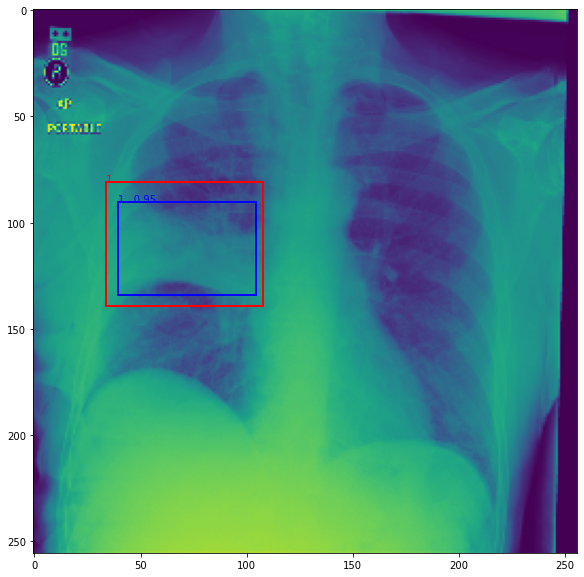

In [72]:
## Plot both the predicted and ground truth boxes on the image
def plotPredictGT(image,width, height, targetGT, targetPredict, colorGT, colorPredict):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    image = image.reshape(width, height, -1)
    a.imshow(image)
    ## get the context for drawing boxes
    ax = plt.gca()
    ## Plot each box
    for i in range(len(targetGT['boxes'])):
        box = targetGT['boxes'][i]
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        ## Create rectangle patch for bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = colorGT, facecolor = 'none')
        ax.add_patch(rect)
        ## Draw text on top of box
        label = "%s" % (classes[targetGT['labels'][i]])
        plt.text(x, y, label, color= colorGT)
    for i in range(len(targetPredict['boxes'])):
        box = targetPredict['boxes'][i]
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        ## Create rectangle patch for bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = colorPredict, facecolor = 'none')
        ax.add_patch(rect)
        ## Draw text on top of box
        label = "%s   %0.2f" % (classes[targetPredict['labels'][i]], targetPredict['scores'][i])
        plt.text(x, y, label, color= colorPredict)
    ## show the plot
    plt.show()
    
## Plot a sample image. Blue is predicted, red is GT
threshPredict = thresholdBB(prediction, 0.55)
plotPredictGT(image, 256, 256, target, threshPredict, 'r', 'b')

In [73]:
## Random image from test dataset
image, target = dataTest[107]
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    
print('Predicted number of boxes: ', len(prediction['labels']))
print('True number of boxes: ', len(target['labels']))

Predicted number of boxes:  11
True number of boxes:  1


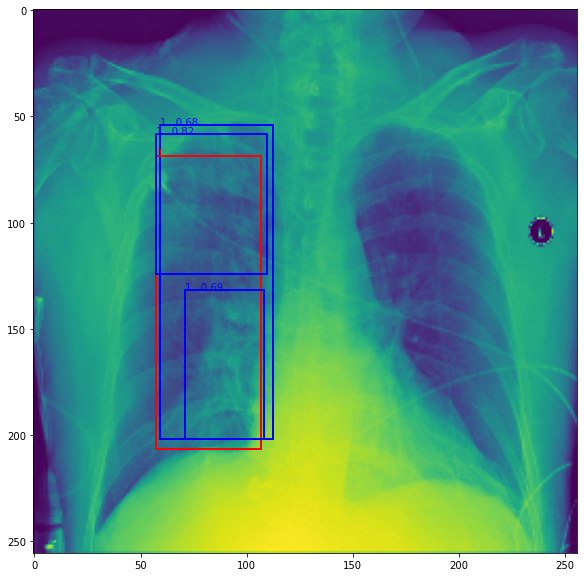

In [ ]:
## Plot a sample image. Blue is predicted, red is GT
threshPredict = thresholdBB(prediction, 0.55)
plotPredictGT(image, 256, 256, target, threshPredict, 'r', 'b')